In [22]:
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

--2023-09-13 13:49:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.199.251, 216.58.200.27, 142.251.223.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.199.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: '10_food_classes_10_percent.zip'

     0K .......... .......... .......... .......... ..........  0% 1.25M 2m9s
    50K .......... .......... .......... .......... ..........  0%  210K 7m37s
   100K .......... .......... .......... .......... ..........  0%  538K 6m46s
   150K .......... .......... .......... .......... ..........  0%  528K 6m23s
   200K .......... .......... .......... .......... ..........  0%  637K 5m58s
   250K .......... .......... .......... .......... ..........  0% 1011K 5m25s
   300K .......... .......... .......... .......... ..........  0% 1.41

In [2]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [17]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();     

In [9]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size = IMAGE_SHAPE,
                                               batch_size = BATCH_SIZE,
                                               class_mode = "categorical")

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size = IMAGE_SHAPE,
                                              batch_size = BATCH_SIZE,
                                              class_mode = "categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [10]:
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
    )
    
    print(f"Saving TensorBoard log files to: {log_dir}")
    
    return tensorboard_callback

In [14]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [15]:
def create_model(model_url, num_classes = 10):
    feature_extractor_layer = hub.KerasLayer(model_url, trainable = False, name = 'feature_extraction_layer', 
        input_shape = IMAGE_SHAPE + (3,))
    
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')      
    ])
        
    return model

In [19]:
resnet_model = create_model(resnet_url, num_classes = train_data_10_percent.num_classes)

resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [20]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                         experiment_name = "resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230913-163843
Epoch 1/5
24/24 [==============================] - 130s 5s/step - loss: 2.0336 - accuracy: 0.3493 - val_loss: 1.2480 - val_accuracy: 0.6140
Epoch 2/5
24/24 [==============================] - 144s 6s/step - loss: 0.9493 - accuracy: 0.7360 - val_loss: 0.8862 - val_accuracy: 0.7192
Epoch 3/5
24/24 [==============================] - 169s 7s/step - loss: 0.6508 - accuracy: 0.8147 - val_loss: 0.7653 - val_accuracy: 0.7516
Epoch 4/5
24/24 [==============================] - 168s 7s/step - loss: 0.4996 - accuracy: 0.8707 - val_loss: 0.7234 - val_accuracy: 0.7676
Epoch 5/5
24/24 [==============================] - 150s 6s/step - loss: 0.4010 - accuracy: 0.9080 - val_loss: 0.6893 - val_accuracy: 0.7764


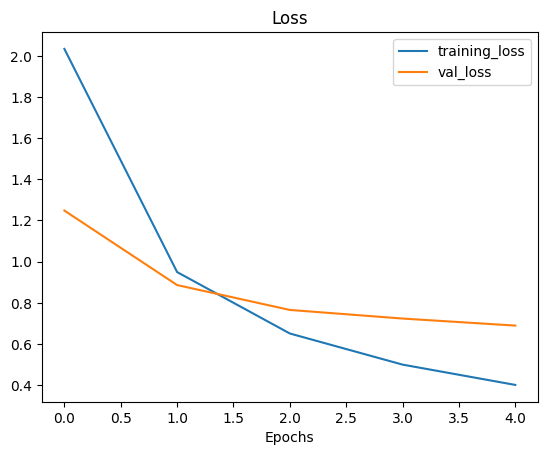

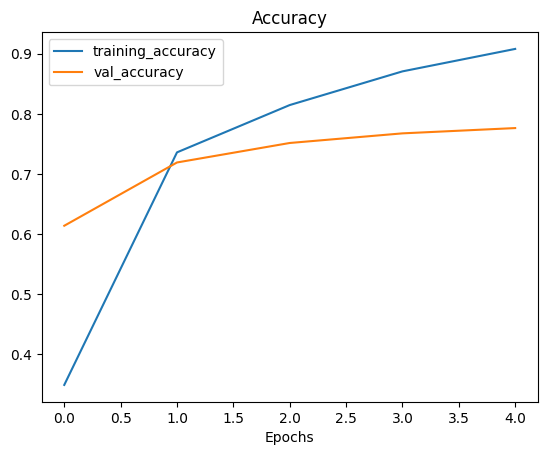

In [23]:
plot_loss_curves(resnet_history)

In [24]:
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes = train_data_10_percent.num_classes)

efficientnet_model.compile(loss = 'categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])

efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [25]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs = 5,
                                              steps_per_epoch = len(train_data_10_percent),
                                              validation_data = test_data,
                                              validation_steps = len(test_data),
                                              callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub", 
                                                                                     experiment_name = "efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230913-165516
Epoch 1/5
24/24 [==============================] - 99s 4s/step - loss: 1.8680 - accuracy: 0.4467 - val_loss: 1.3000 - val_accuracy: 0.7476
Epoch 2/5
24/24 [==============================] - 88s 4s/step - loss: 1.0722 - accuracy: 0.7653 - val_loss: 0.8605 - val_accuracy: 0.8260
Epoch 3/5
24/24 [==============================] - 93s 4s/step - loss: 0.7489 - accuracy: 0.8480 - val_loss: 0.6908 - val_accuracy: 0.8476
Epoch 4/5
24/24 [==============================] - 92s 4s/step - loss: 0.6019 - accuracy: 0.8760 - val_loss: 0.6042 - val_accuracy: 0.8564
Epoch 5/5
24/24 [==============================] - 93s 4s/step - loss: 0.5081 - accuracy: 0.8960 - val_loss: 0.5492 - val_accuracy: 0.8664


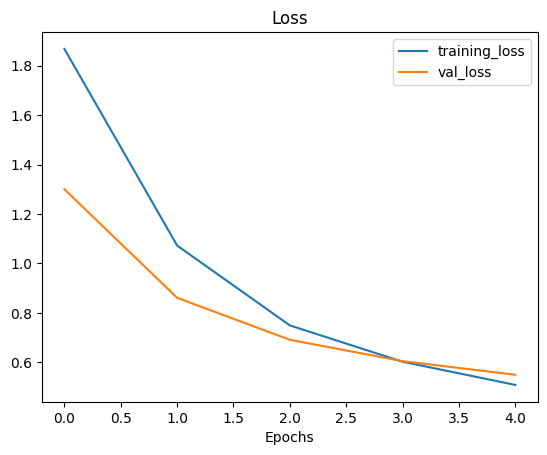

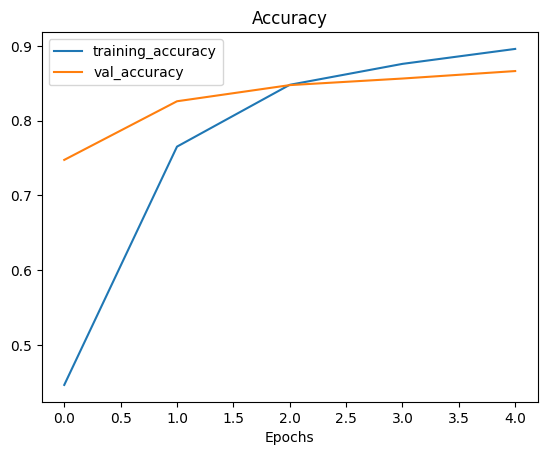

In [26]:
plot_loss_curves(efficientnet_history)

In [28]:
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#   --name "EfficientNetB0 vs. ResNet50V2" \
#   --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
#   --one_shot

In [29]:
# !tensorboard dev list

In [30]:
# !tensorboard dev delete --experiment_id n6kd8XZ3Rdy1jSgSLH5WjA